<a href="https://colab.research.google.com/github/xenidegracia/DataVizClassNotes/blob/main/Distributions_mynotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# load packages
if(!require(pacman))
  install.packages("pacman")

pacman::p_load(countdown,
               tidyverse,
               glue,
               scales,
               ggthemes,
               gt,
               Lahman,
               ggridges)

# set theme for ggplot2
ggplot2::theme_set(ggplot2::theme_minimal(base_size = 12))

# set width of code output
options(width = 65)


Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘prismatic’



countdown installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


ggthemes installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘V8’, ‘reactR’, ‘bigD’, ‘bitops’, ‘juicyjuice’, ‘markdown’, ‘reactable’



gt installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Lahman installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


ggridges installed



In [2]:
library(Lahman)
names(Batting)

[1] "playerID" "yearID"   "stint"    "teamID"   "lgID"    
 [6] "G"        "AB"       "R"        "H"        "X2B"     
[11] "X3B"      "HR"       "RBI"      "SB"       "CS"      
[16] "BB"       "SO"       "IBB"      "HBP"      "SH"      
[21] "SF"       "GIDP"

# Context 1
There are many players in the dataset that played very little games per year, so we will limit to players that played at least 100 games in a given year, with the following years excepted:

*   In 1994 only about 115 games were played due to labor strikes, so will filter to at least 70 games.
*   In 2020 COVID shortened the season to only 60 games, so we will filter at least 40 games.



In [3]:
home_runs <- Batting |>
  filter(
    G >= 100 |
    (G >= 40 & yearID == 2020) |
    (G >= 70 & yearID == 1994)
  )

# Context 2
We are only concerned with years after 1920 (known as the “live-ball era”).
Very few home runs were hit before 1920 as the same baseball was used for the entire game. About 100 baseballs are used every game today!

In [5]:
home_runs <- Batting |>
  filter(
    G >= 100 |
    (G >= 40 & yearID == 2020) |
    (G >= 70 & yearID == 1994),
    yearID > 1920
  )

# Context 3
We are only considering the `AL` and `NL` leagues as they have the best stat-tracking and are the only Major leagues still around today.

In [6]:
home_runs <- Batting |>
  filter(
    G >= 100 |
    (G >= 40 & yearID == 2020) |
    (G >= 70 & yearID == 1994),
    yearID > 1920,
    lgID %in% c("AL", "NL")
  )

# Density Graph Example

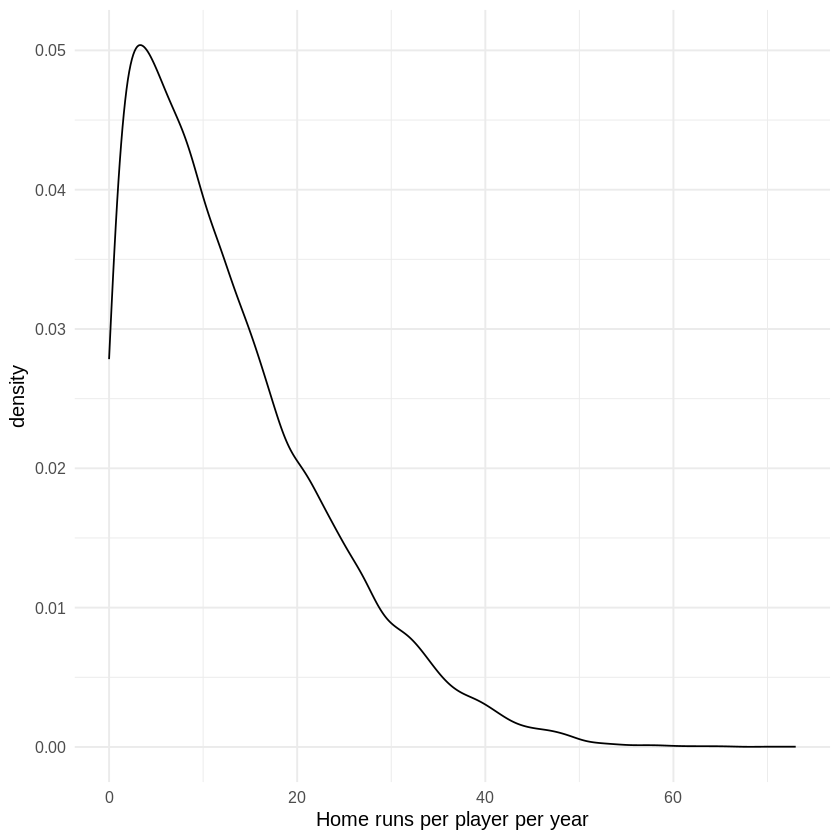

In [7]:
ggplot(home_runs, aes(HR)) +
  geom_density() +
  xlab("Home runs per player per year")

*   Most players hit just a few home runs per year and the distribution is very right-skewed.
*   Very few players hit more than 40 per year.

# Stacked Density Graph By Decade

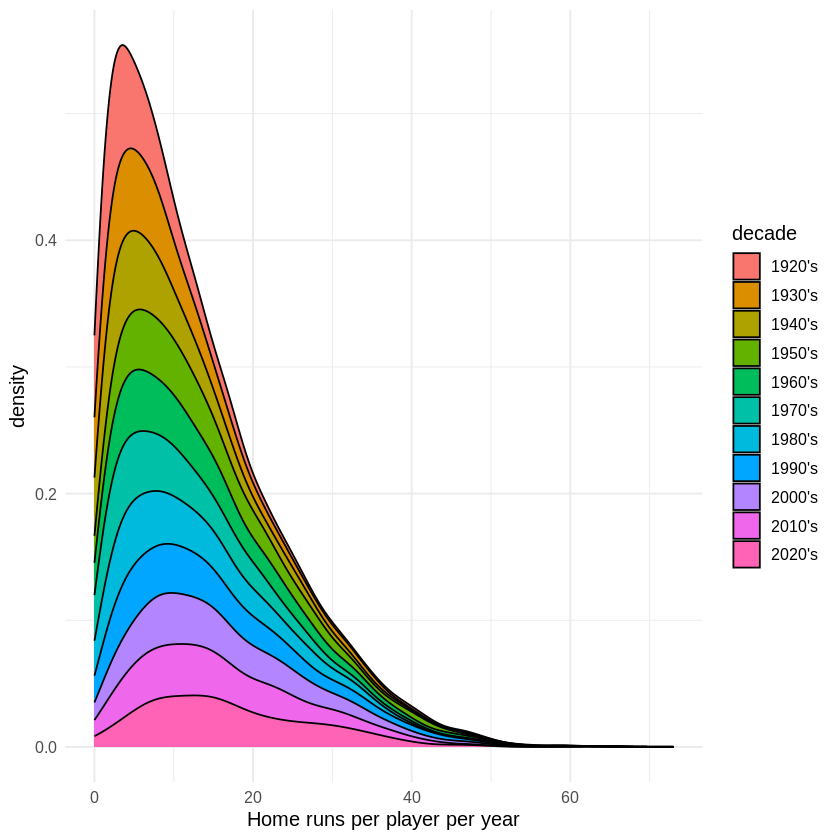

In [8]:
home_runs |>
  mutate(
    decade = cut(
      yearID,
      breaks = seq(1920, 2030, 10),
      labels = paste0(seq(1920, 2020, 10), "'s")
    )
  ) |>
  ggplot(aes(HR, fill = decade)) +
  geom_density(position = "stack") +
  labs(x = "Home runs per player per year")

If we stratify by decade, we can see the mode of the density graphs slowly creep forward, but it is difficult to see the tail of the distribution.

# Overlapping Density Graphs By Decade

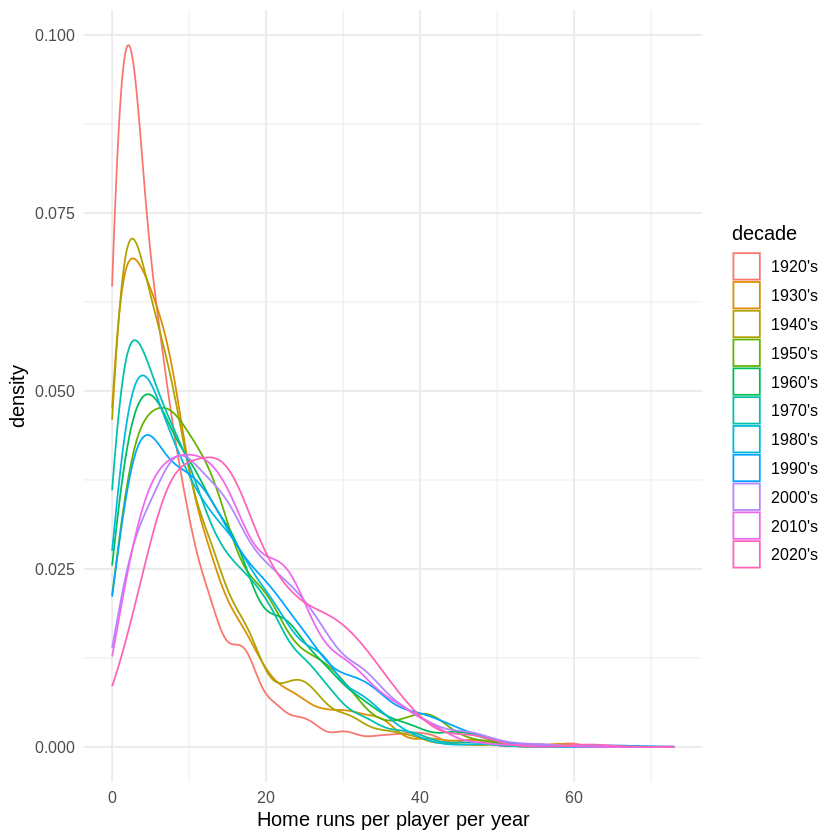

In [9]:
home_runs |>
  mutate(
    decade = cut(
      yearID,
      breaks = seq(1920, 2030, 10),
      labels = paste0(seq(1920, 2020, 10), "'s")
    )
  ) |>
  ggplot(aes(HR, color = decade)) +
  geom_density() +
  labs(x = "Home runs per player per year")

The modes moving forward is a little more apparent now, but the graphs are too coupled to digest easily.

# Density Graph with Conditional Probabilities

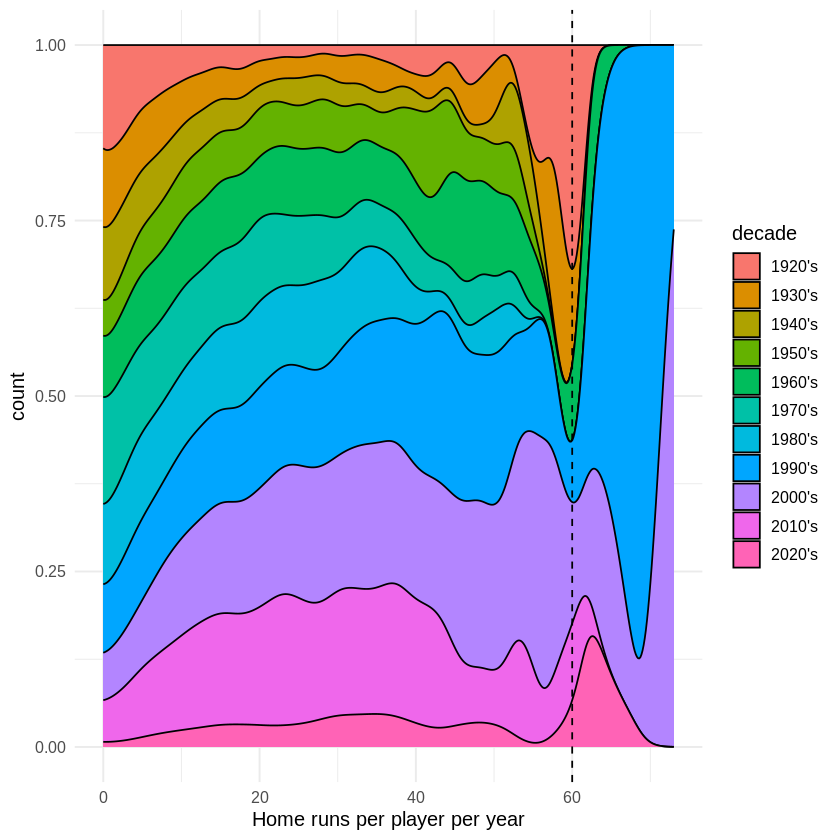

In [10]:
home_runs |>
  mutate(
    decade = cut(
      yearID,
      breaks = seq(1920, 2030, 10),
      labels = paste0(seq(1920, 2020, 10), "'s")
    )
  ) |>
  ggplot(aes(x = HR, y = after_stat(count), fill = decade)) +
  geom_density(position = "fill") +
  geom_vline(xintercept = 60, linetype = "dashed") +
  labs(x = "Home runs per player per year")

By using position = "fill" and y = after_stat(count) we graph the conditional probability of a decade given that a player has hit a certain number of home runs. We see that players would hit about 60 homeruns in the 20’s and 30’s, but that disappears until the 90’s and 2000’s.

*With the exception of 1961, the year Roger Maris hit 61 home runs

# Violin Plot

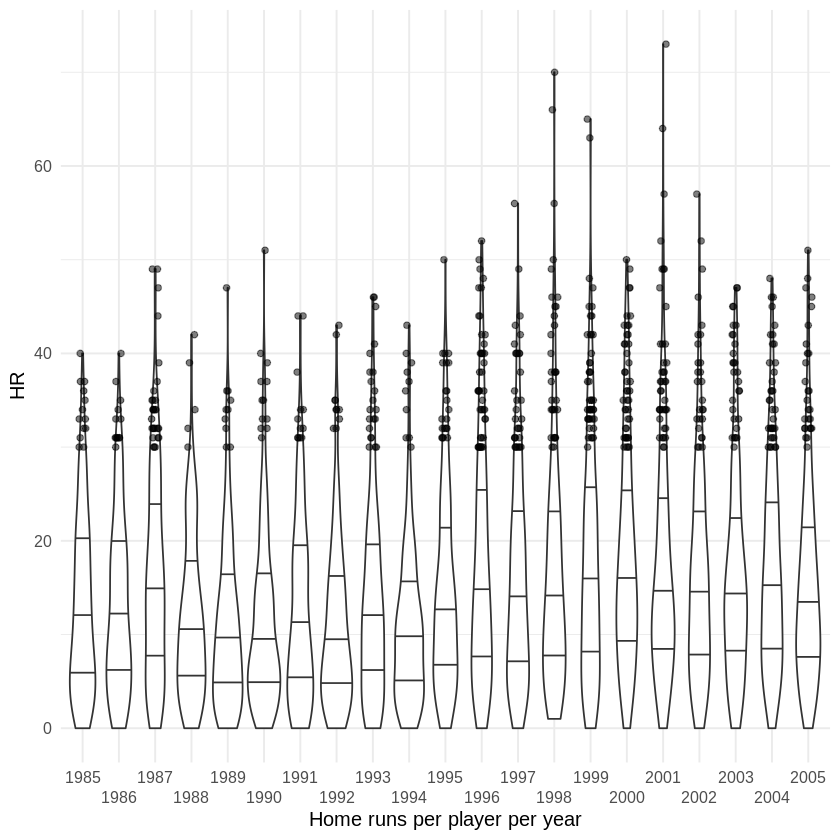

In [11]:
home_runs |>
  filter(yearID %in% 1985:2005) |>
  ggplot(aes(HR, x = factor(yearID))) +
  geom_violin(draw_quantiles = c(0.25, 0.5, 0.75)) +
  geom_jitter(
    data = ~ filter(.x, HR >= 30),
    height = 0, width = 0.1, alpha = 0.5
  ) +
  scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
  labs(x = "Home runs per player per year")

Let’s examine the years near the change point, 1985 to 2005. All points shown are players that hit 30 or more home runs in a given year. It looks like around 1995 players started hitting a lot more home runs.

# Ridge Plot

Picking joint bandwidth of 3.07



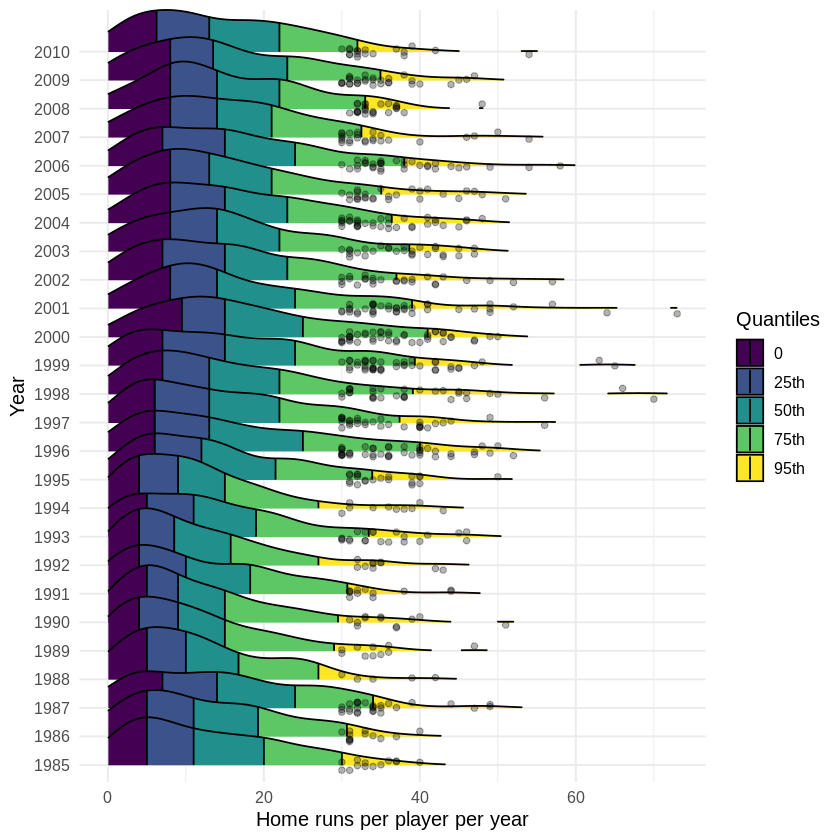

In [12]:
library(ggridges)

home_runs |>
  filter(yearID %in% 1985:2010) |>
  ggplot(aes(x = HR, y = factor(yearID))) +
  stat_density_ridges(
    mapping = aes(fill = factor(after_stat(quantile))),
    geom = "density_ridges_gradient",
    calc_ecdf = TRUE,
    quantiles = c(.25, .50, .75, .95),
    quantile_lines = TRUE,
    scale = 2,
    rel_min_height = 0.01
  ) +
  scale_fill_viridis_d(
    name = "Quantiles",
    labels = c("0", "25th", "50th", "75th", "95th")
  ) +
  geom_jitter(
    data = ~ filter(.x, HR >= 30),
    height = 0.2, width = 0, alpha = 0.3,
  ) + #The jitter function skweed the datapoint to not fall over the line on the plot, so the points are seen better
  scale_x_continuous(
    name = "Home runs per player per year",
    limits = c(0, 73)
  ) +
  labs(y = "Year")

The quantiles also have a consistent increase, along with many more players hitting 30 or more home runs! In 1998 there was a home run record race between two players; this brought a lot of interest back into baseball. 1995 to about 2005 is known as the Steroid Era in baseball. During this time, players would take performance enhancing drugs freely as the league did not enforce the ban on them. League-wide testing began in 2003.

**RETURN** TO SLIDES

# Cautions

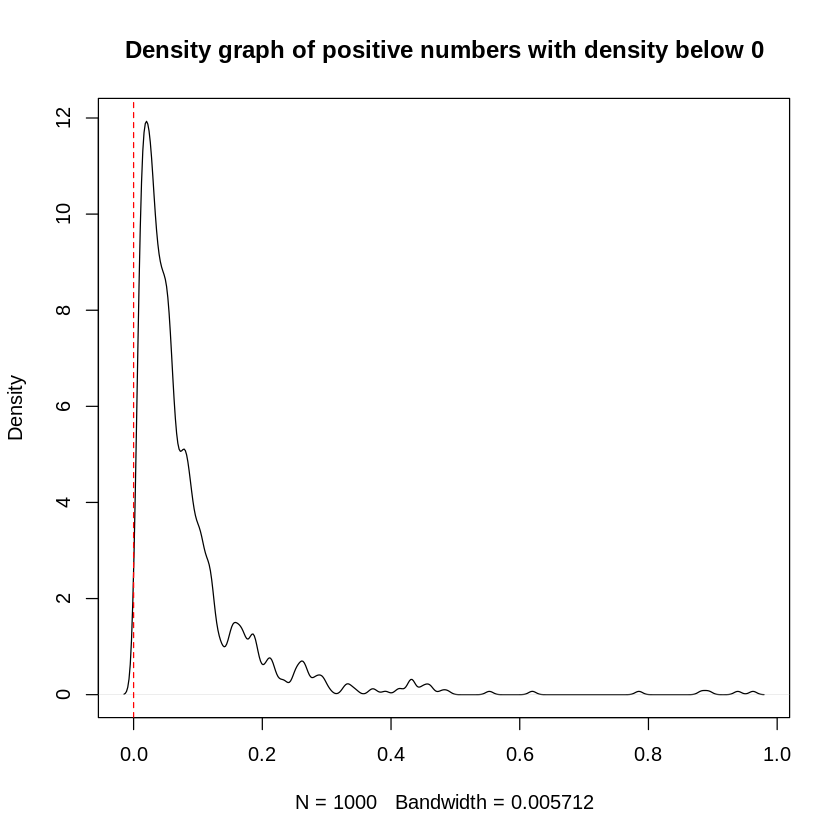

In [13]:
#Density Below 0

long_tailed_data <- tibble(random_values = rlnorm(1000, -3, 1))

plot(
  density(long_tailed_data$random_values, bw = "SJ"),
  main = "Density graph of positive numbers with density below 0"
)
abline(v = 0, col = "red", lty = 2)

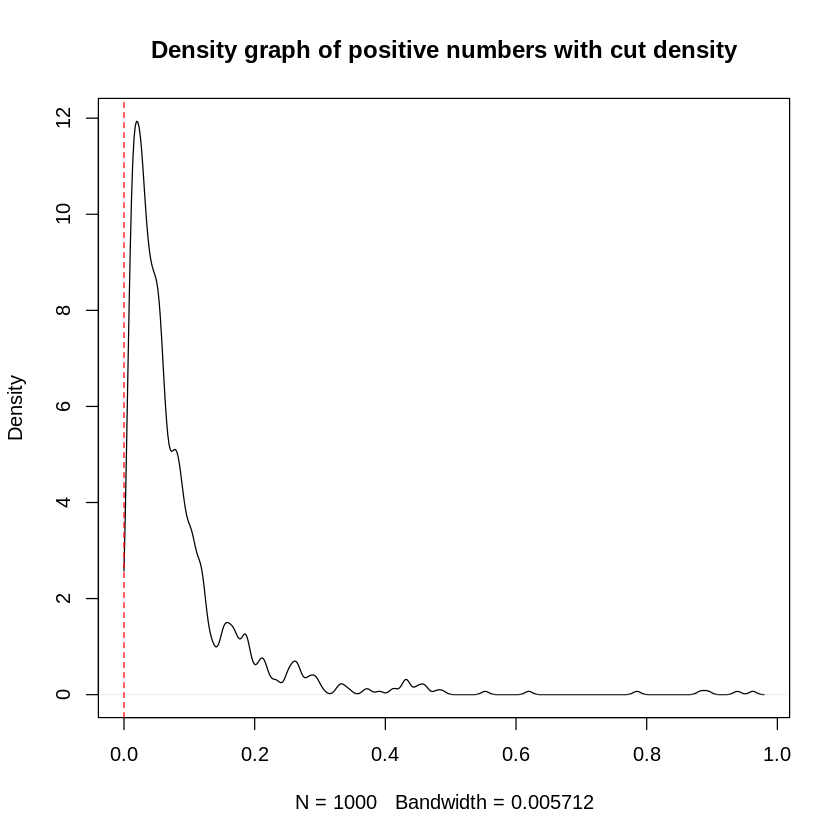

In [14]:
plot(
  density(long_tailed_data$random_values, bw = "SJ", from = 0),
  main = "Density graph of positive numbers with cut density"
)
abline(v = 0, col = "red", lty = 2)

ggplot2 generally handles this for you by putting bounds at the range of your data, but it can occasionally skip this depending on how complicated your graph becomes.

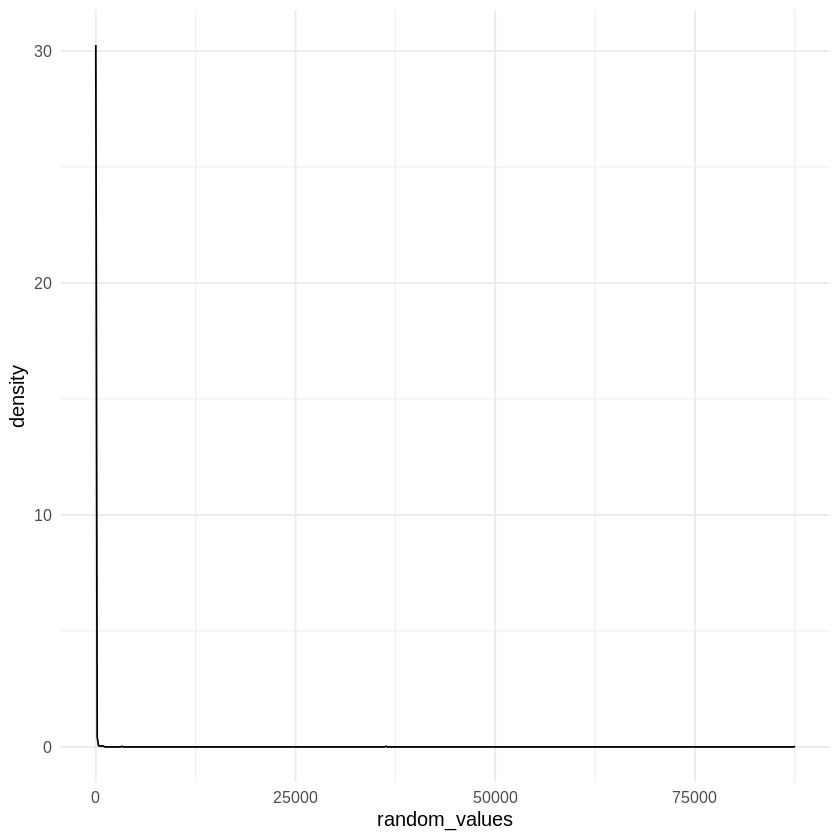

In [15]:
#Long tailed data

longer_tailed_data <- tibble(random_values = rlnorm(1000, -6, 5))

ggplot(longer_tailed_data, aes(x = random_values)) +
  geom_density()

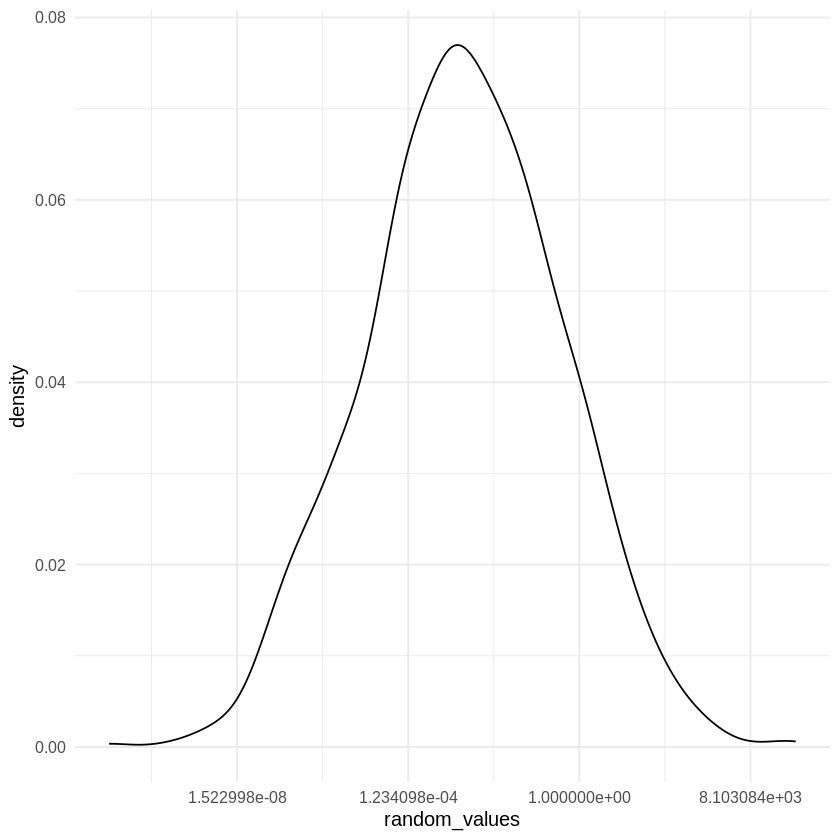

In [16]:
ggplot(longer_tailed_data, aes(x = random_values)) +
  geom_density() +
  scale_x_continuous(trans = "log")

This occurs in our regular work often.

#2D Density/Histograms
Players that hit lots of homeruns tend to strike out and walk more.

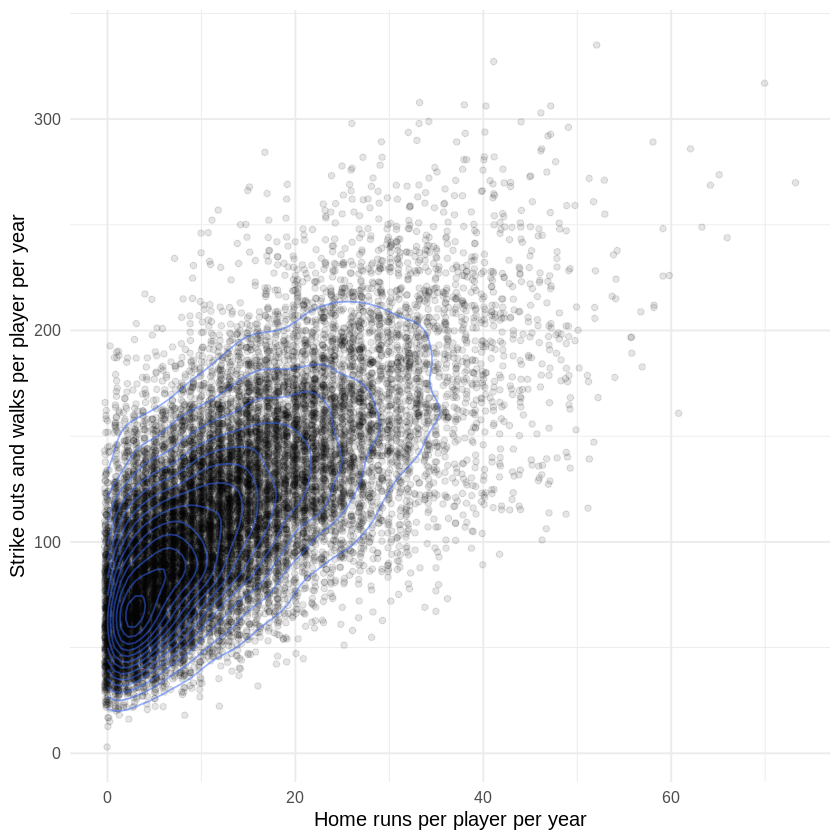

In [17]:
#Scatterplot
home_runs |>
  ggplot(aes(x = HR, y = SO + BB)) +
  geom_jitter(width = 0.3, height = 0.3, alpha = 0.1) +
  geom_density_2d(alpha = 0.5) +
  labs(
    x = "Home runs per player per year",
    y = "Strike outs and walks per player per year"
  )

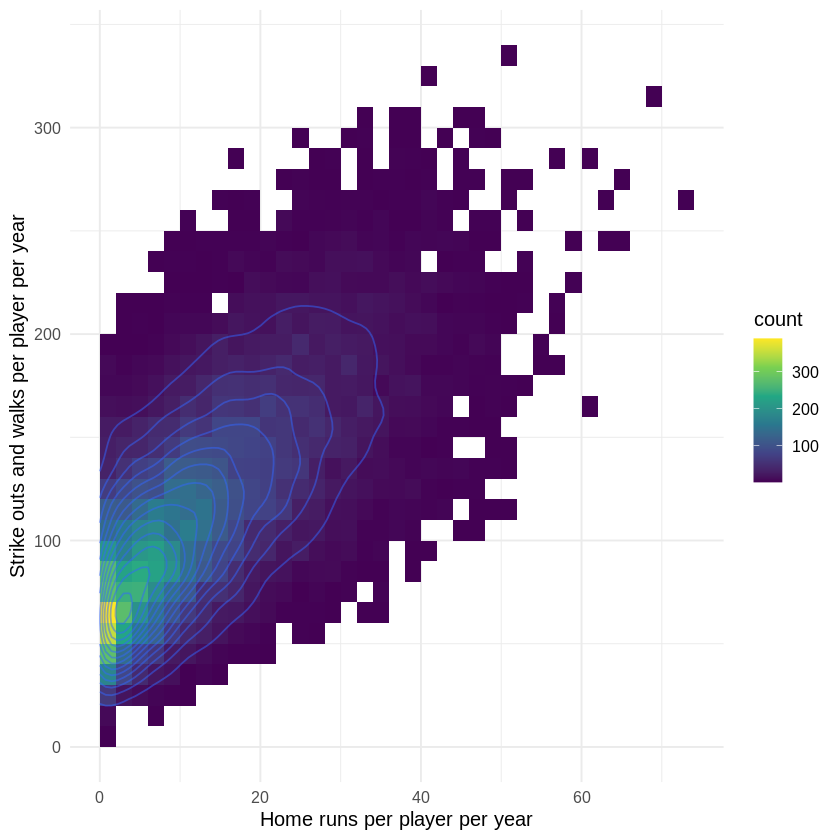

In [18]:
#2D Bins
home_runs |>
  ggplot(aes(x = HR, y = SO + BB)) +
  geom_bin_2d(binwidth = c(2, 10)) +
  geom_density_2d(alpha = 0.5) +
  labs(
    x = "Home runs per player per year",
    y = "Strike outs and walks per player per year"
  ) +
  scale_fill_viridis_c()

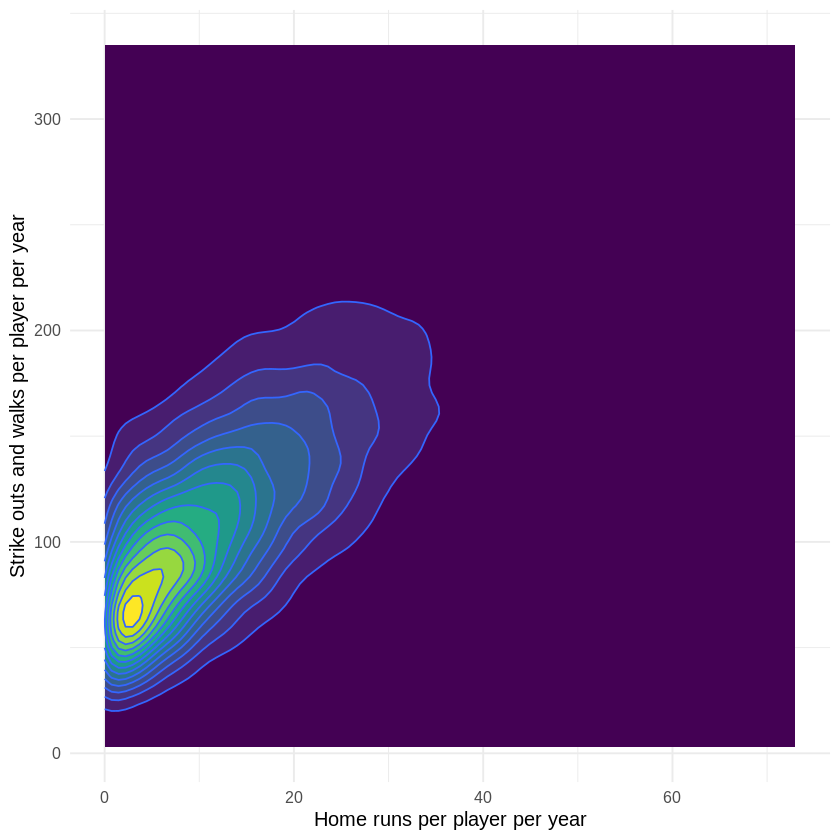

In [19]:
#2D Density
home_runs |>
  ggplot(aes(x = HR, y = SO + BB)) +
  geom_density_2d_filled(show.legend = FALSE) +
  geom_density_2d() +
  labs(
    x = "Home runs per player per year",
    y = "Strike outs and walks per player per year"
  )